# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="white", color_codes=True)
import io

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1440531949061959269
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10252124651308129382
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 815306316990455359
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12907033274028002697
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12433092513884643325
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:86:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_typ

In [5]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [6]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [8]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [9]:
# plot_angles_count(angles_true)

---

## Prepare for training

In [10]:
from sklearn.model_selection import train_test_split
#from cryoem.distance_estimation import create_pairs

In [11]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

#### Global standardization of projections

In [12]:
from cryoem.distance_estimation import global_standardization

In [13]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


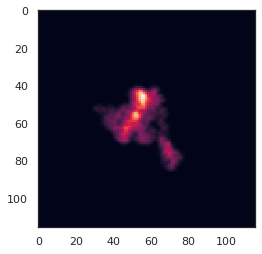

In [14]:
plt.imshow(X[0]);

In [15]:
from skimage.transform import rescale

In [16]:
X.shape

(5000, 116, 116)

In [17]:
def rescale_images(original_images):
    mobile_net_possible_dims = [128, 160, 192, 224]
    dim_goal = 128
    
    for dim in mobile_net_possible_dims:
        if original_images.shape[1] <= dim:
            dim_goal = dim
            break;
    print(f"Image rescaled from dimension {original_images.shape[1]} to {dim_goal} for MobileNet")
    scale = dim_goal/original_images.shape[1]
    images = np.empty((original_images.shape[0], dim_goal, dim_goal))
    for i, original_image in enumerate(original_images):
        images[i] = rescale(original_image, (scale, scale), multichannel=False)
    return images

In [18]:
X = rescale_images(X)

Image rescaled from dimension 116 to 128 for MobileNet


In [19]:
X.shape

(5000, 128, 128)

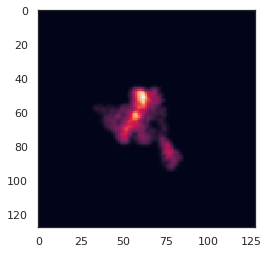

In [20]:
plt.imshow(X[0]);

In [21]:
test_size = 0.33
val_size = 0.25

In [22]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=test_size, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=val_size, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

np.savez("data/5j0n/5j0n_siamese_idx", train_idx, val_idx, test_idx)

In [23]:
print(f"TRAIN: {1-test_size:.2f} x {1-val_size:.2f} = {(1-test_size)*(1-val_size):.2f} => {str(int((1-test_size)*(1-val_size)*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*(1-val_size)*5000, 2))).rjust(10)}")
print(f"TEST : {str(test_size).rjust(18)} => {str(int(test_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power(test_size*5000, 2))).rjust(10)}")
print(f"VAL  : {1-test_size:.2f} x {val_size:.2f} = {(1-test_size)*val_size:.2f} => {str(int((1-test_size)*val_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*val_size*5000, 2))).rjust(10)}")

TRAIN: 0.67 x 0.75 = 0.50 =>  2512 imgs => max pairs:    6312656
TEST :               0.33 =>  1650 imgs => max pairs:    2722500
VAL  : 0.67 x 0.25 = 0.17 =>   837 imgs => max pairs:     701406


In [24]:
np.save("data/5j0n/test_idx", test_idx)

In [25]:
data = np.load("data/5j0n/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [26]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [27]:
X.shape

(5000, 128, 128, 1)

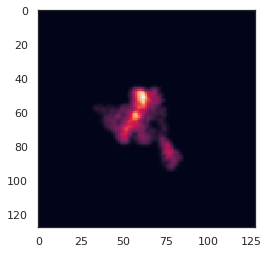

In [28]:
plt.imshow(X[0].squeeze());

# 1. Distance Estimation

### Train the model

In [29]:
from time import time

In [30]:
# dQ_values = np.load("data/5j0n/dQ_values.npy")
# dQ_values = np.around(dQ_values, 1)

# cnt = Counter(dQ_values)
# keys = np.array(list(cnt.keys()))
# #values = sum(cnt.values())/np.array(list(cnt.values()))
# values = np.array(list(cnt.values()))
# #values = np.abs((values - np.mean(values)))/np.std(values)
# #values = 0.037 + values
# print(np.min(values))

# total = sum(cnt.values(), 0.0)
# for key in cnt:
#     cnt[key] /= total

# #coeffs4rprobability = np.polyfit(keys, values, deg=2)
# #convert2rprobability = np.poly1d(coeffs4rprobability)

In [31]:
# dQ_values = np.load("data/5j0n/dQ_values.npy")
# dQ_values = np.around(dQ_values, 1)

# cnt = np.histogram(dQ_values, bins=31, range=(0.0, np.pi), density=True)
# #keys = np.array(list(cnt.keys()))
# #values = sum(cnt.values())/np.array(list(cnt.values()))
# #values = np.array(list(cnt.values()))
# #values = np.abs((values - np.mean(values)))/np.std(values)
# #values = 0.037 + values
# print(np.min(values))

# #total = sum(cnt.values(), 0.0)
# #for key in cnt:
# #    cnt[key] /= total

# #coeffs4rprobability = np.polyfit(keys, values, deg=2)
# #convert2rprobability = np.poly1d(coeffs4rprobability)

In [32]:
# plt.plot(cnt[1][:-1], cnt[0], marker='o')

In [24]:
# idx1 = list(np.random.choice(test_idx, size=100000))
# idx2 = list(np.random.choice(test_idx, size=100000))

# q1_true = euler2quaternion([angles_true[i] for i in idx1])
# q2_true = euler2quaternion([angles_true[i] for i in idx2])

# dQ_values = d_q(q1_true, q2_true).numpy()

# np.save("data/5j0n/dQ_values_100K.npy", dQ_values)

In [25]:
dQ_values = np.load("data/5j0n/dQ_values_100K.npy")

In [26]:
cnt = np.histogram(dQ_values, bins=32, range=(0.0, np.pi), density=True)
probabilities = cnt[0]
weights = 1/probabilities
weights_norm = weights/sum(weights)

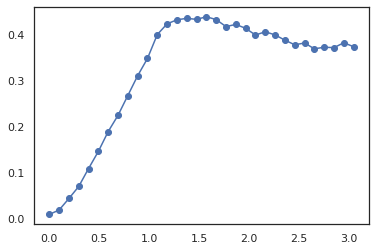

In [27]:
plt.plot(cnt[1][:-1], probabilities, marker='o')

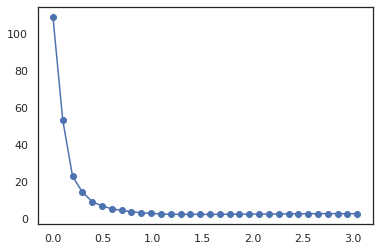

In [28]:
plt.plot(cnt[1][:-1], weights, marker='o')

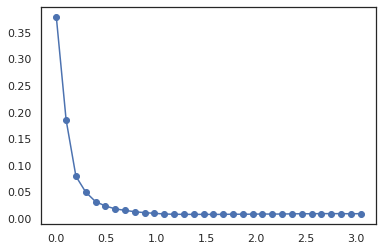

In [29]:
plt.plot(cnt[1][:-1], weights_norm, marker='o')

In [30]:
# NO UNIFORM, RANDOM FULL PROBABILITY WEIGHTS
from tensorflow.keras.utils import Sequence

num_dec = 1
num_bins = 32

dQ_values = np.load("data/5j0n/dQ_values_100K.npy")
distribution = np.histogram(dQ_values, bins=32, range=(0.0, np.pi), density=True)
probabilities = distribution[0]
weights = 1/probabilities
weights_norm = weights/sum(weights)

class DataGenerator(Sequence):
    
    def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
        self.X = X  
        self.y = y  
        self.limit_num_pairs = limit_num_pairs
        # all the possible combinations of 2 image id pairs
        self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
        # Don't use all possible combination of pairs, limit them here
        if self.limit_num_pairs and limit_style=="random":
            limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
            self.pair_ids = self.pair_ids[limited_pair_indices]
      
        self.batch_size = batch_size    
        self.shuffle = shuffle 
        self._on_epoch_start()
    
    def __len__(self):
        # Denotes the number of batches per epoch
        if len(self.pair_ids)%self.batch_size == 0:
            return len(self.pair_ids) // self.batch_size
        else:
            return len(self.pair_ids) // self.batch_size + 1
        
    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of ids
        list_ids_batch = np.take(self.pair_ids, indices, axis=0)

        # Generate data
        idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
        pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
        labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))  # shape: len(idx1)
        #weights = np.array(self._get_weights(labels))
        #labels_and_weights = np.stack((labels, weights), axis=1)
        
        # [training_pairs[:, 0], training_pairs[:, 1]], labels_and_weights
        #return [pairs[:, 0, :, :, np.newaxis], pairs[:, 1, :, :, np.newaxis]], labels  #labels_and_weights
        return [pairs[:, 0], pairs[:, 1]], labels  #labels_and_weights
    
    def _get_weights(self, labels):
        l = labels.numpy()
        return np.array(list(map(lambda x: probabilities[np.where(x >= distribution[1])[0][-1]], l)))
        
    def _on_epoch_start(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pair_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)     

In [47]:
# # CALCULATE FULL - UNIFORM
# from tensorflow.keras.utils import Sequence

# num_dec = 1
# num_bins = 32

# class DataGenerator(Sequence):
    
#     def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
#         start_time = time()
#         if batch_size > limit_num_pairs:
#             raise Exception("Please specify limit_num_pairs that is much higher than batch_size")
#         self.X = X  
#         self.y = y  
#         self.limit_num_pairs = limit_num_pairs
#         self.list_ids = list_ids
#         self.batch_size = batch_size  
#         # all the possible combinations of 2 image id pairs
#         self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
#         # Don't use all possible combination of pairs, limit them here
#         if self.limit_num_pairs:
#             limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
#             self.pair_ids = self.pair_ids[limited_pair_indices]
        
#         if limit_style=="uniform":
#             self.pair_ids = self._generate_uniform()
  
#         self.shuffle = shuffle 
#         self._on_epoch_start()
#         print(f"Data created in {time()-start_time} sec")
        
        
#     def _generate_uniform(self):
#         if os.path.exists(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy"):
#             return np.load(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy")
#         else:
#             bins = {}
#             for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
#                 bins[np.around(i, num_dec)] = []


#             for idx1, idx2 in self.pair_ids:
#                 label = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))
#                 bins[np.around(label, num_dec)].append([idx1, idx2])

#             #for b in bins:
#             #    print(b, len(bins[b]))

#             min_bin_size = len(bins[min(bins.keys(), key=lambda x: len(bins[x]))])
#             print("min=", min_bin_size)
#             if min_bin_size == 0:
#                 raise Exception("It haven't yet managed to fill all the bins, please increase limit_num_pairs")


#             # cut the top of histogram to make it uniform
#             for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
#                 b = np.around(i, num_dec)
#                 #print(bins[b])
#                 bins[b] = np.take(bins[b], np.arange(min_bin_size), axis=0)  

#             #print(bins)
#             l = np.array(list(itertools.chain(*list(bins.values()))))
#             np.save(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy", l)
#             print("total number of data = ", 31*min_bin_size)
#             #print(l)
#             return l
    
#     def __len__(self):
#         # Denotes the number of batches per epoch
#         if len(self.pair_ids)%self.batch_size == 0:
#             return len(self.pair_ids) // self.batch_size
#         else:
#             return len(self.pair_ids) // self.batch_size + 1
        
#     def __getitem__(self, index):
#         # Generate one batch of data
#         indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
#         # Find list of ids
#         list_ids_batch = np.take(self.pair_ids, indices, axis=0)

#         # Generate data
#         idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
#         pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
#         labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))  # shape: len(idx1)
#         #weights = np.array(self._get_weights(labels))
#         #labels_and_weights = np.stack((labels, weights), axis=1)
        
#         # [training_pairs[:, 0], training_pairs[:, 1]], labels_and_weights
#         return [pairs[:, 0], pairs[:, 1]], labels   #labels_and_weights
        
#     def _on_epoch_start(self):
#         # Updates indices after each epoch
#         self.indices = np.arange(len(self.pair_ids))
#         if self.shuffle:
#             np.random.shuffle(self.indices)     

In [48]:
# # CALCULATE PER BATCH
# from tensorflow.keras.utils import Sequence

# num_dec = 1
# num_bins = 32

# class DataGenerator(Sequence):
    
#     def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=False):
#         self.X = X  
#         self.y = y  
#         self.limit_num_pairs = limit_num_pairs
#         # all the possible combinations of 2 image id pairs
#         self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
#         self.limit_style = limit_style
        
#         # Don't use all possible combination of pairs, limit them here
#         if self.limit_num_pairs:
#             limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
#             self.pair_ids = self.pair_ids[limited_pair_indices]
      
#         self.batch_size = batch_size    
#         self.shuffle = shuffle 
#         self._on_epoch_start()
#         self.index = 0
        
#     def _all_bins_filled(self, bins):
#         for v in bins.values():
#             if len(v) <= self.batch_size//num_bins:
#                 return False
#         return True
    
#     def _generate_uniform(self):
#         bins = {}
#         for i in np.linspace(0.0, 3.1, num=num_bins): # so we have 31 bin
#             bins[np.around(i, num_dec)] = []

#         for i, (idx1, idx2) in enumerate(self.pair_ids[self.index:]):
#             label = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))
#             if len(bins[np.around(label, num_dec)]) <= self.batch_size//num_bins:
#                 bins[np.around(label, num_dec)].append([idx1, idx2])
                
#             if self._all_bins_filled(bins):
#                 self.index += i
#                 break
#         else:
#             # if it didn't fill the bins, reset the index
#             self.index = 0
        
#         return np.array(list(itertools.chain(*list(bins.values()))))
    
#     def __len__(self):
#         # Denotes the number of batches per epoch
#         if len(self.pair_ids)%self.batch_size == 0:
#             return len(self.pair_ids) // self.batch_size
#         else:
#             return len(self.pair_ids) // self.batch_size + 1
        
#     def __getitem__(self, index):
#         if self.limit_style=="random":
#             # Generate one batch of data
#             indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

#             # Find list of ids
#             list_ids_batch = np.take(self.pair_ids, indices, axis=0)
#         elif self.limit_style=="uniform":
#             list_ids_batch = self._generate_uniform()

#         # Generate data
#         idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
#         pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
#         labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))  # shape: len(idx1)
#         #weights = np.array(self._get_weights(labels))
#         #labels_and_weights = np.stack((labels, weights), axis=1)
        
#         # [training_pairs[:, 0], training_pairs[:, 1]], labels_and_weights
#         return [pairs[:, 0], pairs[:, 1]], labels   #labels_and_weights
        
#     # def _get_weights(self, labels):
#     #      return convert2rprobability(labels)
        
#     def _on_epoch_start(self):
#         # Updates indices after each epoch
#         self.indices = np.arange(len(self.pair_ids))
#         if self.shuffle:
#             np.random.shuffle(self.indices)     

In [49]:
# idx1 = list(np.random.choice(test_idx, size=1000))
# idx2 = list(np.random.choice(test_idx, size=1000))

# q1_true = euler2quaternion([angles_true[i] for i in idx1])
# q2_true = euler2quaternion([angles_true[i] for i in idx2])

# dQ_values = d_q(q1_true, q2_true).numpy()

In [57]:
# plt.hist(dQ_values, bins=100);

In [58]:
# plt.plot(np.arange(0,np.pi,0.01), convert2rprobability(np.arange(0,np.pi,0.01)), marker="*", markersize=2, lw=0, c="r");

In [59]:
# np.min(convert2rprobability(np.arange(0,np.pi,0.01)))

In [37]:
# len(train_idx)

In [45]:
start_time = time()
g = DataGenerator(X, y, train_idx, limit_num_pairs=10)
print(time()-start_time)
dQ_values_dg = []
print(len(g))
for i in g:
    #dQ_values_dg.extend(list(i[1]))
    #print(len(i))
    print(len(i[0]))
    print(i[0][0].shape)
    #print(i[1][0], i[1][1])
print(time() - start_time)

4.1667468547821045
1
2
(10, 128, 128, 1)
4.1783528327941895


In [39]:
# start_time = time()
# g = DataGenerator(X, y, train_idx, limit_num_pairs=5000, limit_style="uniform")
# print(time()-start_time)
# dQ_values_dg = []
# for i in g:
#     #print(i[0][0].shape, i[1].shape)
#     dQ_values_dg.extend(list(i[1].numpy()))
#     #print(np.min(i[0][0]), np.max(i[0][0]))
# print(time() - start_time)

In [40]:
# #dQ_values_dg= np.around(dQ_values_dg, 1)
# plt.hist(dQ_values_dg, bins=32);

In [41]:
# s1 = np.histogram(dQ_values_dg, bins=31, density=True)
# s1

In [42]:
# plt.plot(np.linspace(0, 3.14, num=31), s1[0])

In [43]:
# plt.plot(np.linspace(0, 3.1, 32),np.histogram(dQ_values_dg, bins=32)[0], marker='o')
# plt.hist(dQ_values_dg, bins=32);

In [44]:
# import tensorflow_probability as tfp

In [45]:
# s = tfp.stats.histogram(dQ_values_dg, np.arange(0.0, 3.14, 0.1))
# s /= sum(s.numpy())

In [46]:
# plt.plot(np.linspace(0, 3.14, num=31), s.numpy())

In [47]:
# s3 = get_probabilities(np.array(dQ_values_dg).astype(np.float32))
# s3

In [48]:
# plt.plot(np.linspace(0, 3.14, num=31), s3.numpy())

In [31]:
import tensorflow_probability as tfp
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import KLD, MAE, MSE

_idx1 = list(np.random.choice(val_idx, size=1000))
_idx2 = list(np.random.choice(val_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in _idx1])
q2_true = euler2quaternion([angles_true[i] for i in _idx2])

p1 = [X[i] for i in _idx1]
p2 = [X[i] for i in _idx2]

model = None
        
def get_probabilities(x):
    #probs = np.histogram(x, bins=32, range=(0.0, np.pi), density=True)
    #return probs[0]
    s = tfp.stats.histogram(x, tf.range(0.0, 3.14, 0.01))
    s = tf.math.divide(s, K.sum(s))
    return s

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def mae(y_true, y_pred):
    y_true_probs = get_probabilities(y_true)
    y_pred_prob = get_probabilities(y_pred)
    #y_true, weights = y_true[:, 0], y_true[:, 1]
    return MAE(y_true, y_pred) + K.abs(KLD(y_true_probs, y_pred_prob))#K.mean(weights*K.square(y_true-y_pred)) #weights*K.abs(MAE(y_true, y_pred)) #+ K.abs(KLD(y_true, y_pred))


def mse(y_true, y_pred):
    y_true_probs = get_probabilities(y_true)
    y_pred_prob = get_probabilities(y_pred)
    #y_true, weights = y_true[:, 0], y_true[:, 1]
    return MSE(y_true, y_pred) + K.abs(KLD(y_true_probs, y_pred_prob)) #K.mean(weights*K.abs(y_true-y_pred)) #weights*K.abs(MSE(y_true, y_pred)) #+ K.abs(KLD(y_true, y_pred))

def mlp(vects):
    x, y = vects
    Concatenate(axis=-1)
    
def mlp_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


# def create_siamese_network(input_shape):
#     # first: train only the top layers (which were randomly initialized)
#     # i.e. freeze all convolutional InceptionV3 layers
#     input_x = Input(shape=input_shape)
#     base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_x, input_shape=input_shape)
#     x = base_model.layers[-1].output

#     # add a global spatial average pooling layer
#     x = GlobalAveragePooling2D()(x)

#     return Model(input_x, x)

def create_siamese_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    #print(input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)

def create_distance_network(input_shape):
    # ref: https://github.com/guanjianyu/DisNet/blob/master/Train_DisNet.py
    # ref: https://project.inria.fr/ppniv18/files/2018/10/paper22.pdf
    input_x = Input(shape=input_shape)
    
    #x = Flatten()(input_x)

    x = Dense(2000, activation="relu")(input_x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(1000, activation="relu")(x)
    x = Dense(1000, activation="relu")(x)
    x = Dense(1, activation="relu")(x)
    
    return Model(input_x, x)


def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

In [32]:
_idx1 = list(np.random.choice(val_idx, size=1000))
_idx2 = list(np.random.choice(val_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in _idx1])
q2_true = euler2quaternion([angles_true[i] for i in _idx2])

p1 = [X[i] for i in _idx1]
p2 = [X[i] for i in _idx2]

model = None

def train_siamese(X, y, train_idx, val_idx, epochs_top, batch_size, learning_rate, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None):
    
    
    def d_p(p1, p2):
        global model
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""

        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            #plt.clf()
            dP_values = d_p(p1, p2).T[0]
            dQ_values = d_q(q1_true, q2_true).numpy()
            # Creating the dataframe for SNS plot
            data = {"d_Q" : dQ_values, "d_P" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        try:
            # Prepare data generators
            training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps, shuffle=True)
            validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps, shuffle=True)

            input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
            print(f"Input images shape {input_shape}")

            # network definition
            input_a = Input(shape=input_shape)
            input_b = Input(shape=input_shape)
            cnn_network = create_siamese_network(input_shape)

            # because we re-use the same instance `cnn_network`,
            # the weights of the network will be shared across the two branches
            processed_a = cnn_network(input_a)
            processed_b = cnn_network(input_b)


            distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
            #siamese_output = Concatenate()([processed_a, processed_b])
            #siamese_output = tf.keras.backend.stack([processed_a, processed_b])
            #print(f"Output shape of the SiameseNN {siamese_output.shape}")
            #distance_network = create_distance_network(siamese_output.shape)
            #distance = distance_network(siamese_output)

            global model
            if gpus:
                m = Model([input_a, input_b], distance)  
                model = multi_gpu_model(m, gpus=gpus)
            else:
                model = Model([input_a, input_b], distance)
                
            model.summary()
            plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

            # training only top layers
            optimizer1 = RMSprop(learning_rate=learning_rate)
            model.compile(loss=mae, optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)

            # Setup callbacks
            # Callback that saves the model
            training_description = "_"+training_description if training_description else ""
            CHECKPOINT_PATH = os.path.join("training", f"{strftime('%Y%m%d_%H%M%S')}{training_description}.h5")
            #pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
            backup_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
            print(f"Model will be saved to: {CHECKPOINT_PATH}")
            # Callback that will show tensorboard data
            LOGS_PATH = os.path.join("logs", f"{strftime('%Y%m%d_%H%M%S')}{training_description}")
            pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
            logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
            # Callback for the dP/dQ plot
            file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
            plot_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=generate_dPdQ_plot(file_writer_plot))
            # Callback that will decrease LR if it gets plateau in val_loss
            #reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)

            history = model.fit(training_generator, 
                                epochs=epochs_top,
                                validation_data=validation_generator, 
                                callbacks=[backup_callback, plot_callback, logs_callback])

            if plot:
                # Get training and test loss histories
                training_loss = history.history['loss']
                val_loss = history.history['val_loss']
                mses = history.history['mse']
                val_mses = history.history['val_mse']

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

                # Create count of the number of epochs
                epoch_count = range(1, len(training_loss) + 1)

                # Visualize loss history
                ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
                ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
                ax1.legend()
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')

                ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
                ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
                ax2.legend()
                ax2.set_xlabel('Epoch')
                ax2.set_ylabel('Loss')
                plt.show();


    #         model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
    #         model.save(model_filename) 
    #         print(f"Model saved to: {model_filename}")

            return model, history
    
        except Exception as e:
            print("\n\nTraining interrupted")
            print(e)
            return model, None

In [33]:
train_percent = 0.1
val_percent = 0.1
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(631014, 70224)

In [ ]:
model, history1 = train_siamese(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs_top=20,  #500
                               batch_size=256,  #512 latest 
                               learning_rate=1e-3,  #0.01 
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),  # None
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),  # None
                               plot=True,
                               gpus=2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Input images shape (128, 128, 1)
Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
___________________________________

In [21]:
#from tensorflow.keras.models import load_model
# import tensorflow_hub as hub

# def build_model(loaded, input_shape):
#     input_x = Input(shape=input_shape)
#     # Wrap what's loaded to a KerasLayer
#     keras_layer = hub.KerasLayer(loaded, trainable=True)(input_x)
#     model = tf.keras.Model(x, keras_layer)
#     return model
    
def continue_training(model_filename, X, y, train_idx, val_idx, epochs_top, epochs_full, batch_size, learning_rate, training_steps=None, validation_steps=None, plot=True, gpus=None):
    #tf.enable_eager_execution()
    
    #mirrored_strategy = tf.distribute.MirroredStrategy()
    
    #with mirrored_strategy.scope():
        
    #input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
    #print(f"Input images shape {input_shape}")

    #loaded = tf.saved_model.load('training/20200521_084626.h5')
    #m = build_model(loaded, input_shape)
    #Load partly trained model
    #m = tf.keras.models.load_model('training/20200521_084626.h5')
    m = tf.keras.models.load_model(model_filename)

    # train
    model = multi_gpu_model(m, gpus=gpus)
    model.summary()
    #plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

    training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps)
    validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps)

    # Setup callbacks
    # Create a callback that saves the model's weights
    #CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
    #pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
    #backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
    #                                  save_weights_only=True,
    #                                  verbose=1)
    # Create a callback that will show tensorboard data
    LOGS_PATH = os.path.join("logs", strftime('%Y%m%d_%H%M%S'))
    pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
    logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)

    # Create a callback that will decrease LR if it gets plateau in val_loss
    reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)


    # training only top layers
    optimizer1 = RMSprop(learning_rate=learning_rate)
    model.compile(loss=mae, optimizer=optimizer1, metrics=['mse'])
    #Continue training
    history = model.fit(training_generator, 
                        epochs=epochs_top,
                        validation_data=validation_generator, 
                        callbacks=[logs_callback, reduce_on_plateau_callback])

    return model, history

In [ ]:
model, history2 = continue_training(model_filename='training/20200521_084626.h5',X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs_top=20,  #500
                               epochs_full=None,
                               batch_size=256,  #512 latest 
                               learning_rate=1e-3,  #0.01 
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),  # None
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),  # None
                               plot=True,
                               gpus=2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 116, 116, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 116, 116, 3)  0           input_2[0][0]                    
____________________________________________________________________________________________

---

In [35]:
training_loss = history1.history['loss']
val_loss = history1.history['val_loss']
mses = history1.history['mse']
val_mses = history1.history['val_mse']

np.savez("data/5j0n/5j0n_DE_history_uniform", training_loss, val_loss, mses, val_mses)

In [35]:
# training_loss2 = history2.history['loss']
# val_loss2 = history2.history['val_loss']
# mses2 = history2.history['mse']
# val_mses2 = history2.history['val_mse']

# np.savez("data/5j0n/5j0n_DE_history_stage2", training_loss2, val_loss2, mses2, val_mses2)

In [36]:
# training_loss += training_loss2
# val_loss += val_loss2
# mses += mses2
# val_mses += val_mses

In [36]:
data = np.load("data/5j0n/5j0n_DE_history_uniform.npz")
training_loss, val_loss, mses, val_mses = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]

In [35]:
limit = 9

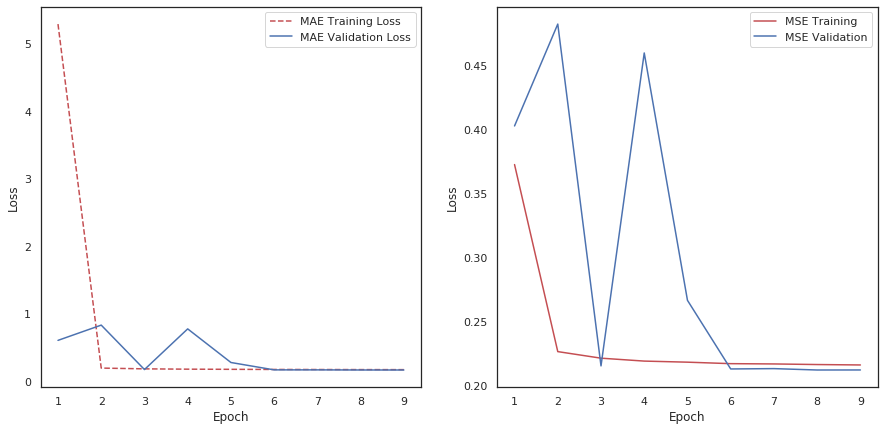

In [36]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count[:limit], training_loss[:limit], 'r--', label='MAE Training Loss')
ax1.plot(epoch_count[:limit], val_loss[:limit], 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count[:limit], mses[:limit], 'r-', label='MSE Training')
ax2.plot(epoch_count[:limit], val_mses[:limit], 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

In [37]:
training_loss[limit], val_loss[limit], mses[limit], val_mses[limit]

(0.1752116043231081, 0.16998578501599176, 0.21599634, 0.21194182)

In [40]:
training_loss[limit], val_loss[limit], mses[limit], val_mses[limit]

(0.00010196198448029379, 0.00013733559804016046, 4.607726e-06, 9.539637e-06)

In [41]:
training_loss[limit], val_loss[limit], mses[limit], val_mses[limit]

(20.34968684555079, 20.15308006286621, 17.759182, 17.617468)

In [37]:
# training_loss[50], val_loss[50], mses[50], val_mses[50]

### (Or) Read model checkpoint

In [40]:
# stop here, change file

In [68]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
#model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training
#model_filename = "training/20200416_094914.h5"
#model_filename = "training/20200417_192953.h5"
#model_filename = "training/20200418_190002.h5"
#model_filename = "training/20200418_190118.h5" for symmetric
#model_filename = "training/20200422_114231.h5"
#model_filename = "training/20200430_022437.h5" full 2
#model_filename = "training/20200430_212106.h5" full 3
#model_filename = "training/20200504_232357.h5"
#model_filename = "training/20200505_191430.h5"  PGN
#model_filename = "training/20200507_070831.h5" 
#model_filename = "training/20200508_020958.h5" # fixed MLP + MobileNet | NOT REALLY was ran with Eucl
# small ds

#model_filename = "training/20200508_020958.h5"
#model_filename = "training/20200526_054602.h5"
#model_filename = "training/20200527_091717.h5"
#model_filename = "training/20200530_103447.h5"
#model_filename = "training/20200601_022855.h5" # KLD
#model_filename = "training/20200530_103447.h5"  # no KLD
#model_filename = "training/20200531_224202.h5" !!!!!!!!!!!!!!!!!!!
#model_filename = "training/20200601_022855.h5" # KLD
model_filename = "training/20200607_183509.h5"

In [69]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
lambda_36 (Lambda)              (None, 116, 116, 3)  0           input_22[0][0]                   
__________________________________________________________________________________________________
lambda_37 (Lambda)              (None, 116, 116, 3)  0           input_23[0][0]                   
___________________________________________________________________________________________

### Some model results

In [38]:
from cryoem.distance_estimation import plot_results

In [126]:
def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
        ax1.imshow(projections[0])
        ax2.imshow(projections[1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

In [139]:
X.shape

(5000, 116, 116)

In [149]:
y_tr_pred = model.predict([X[:1, :,:,:], X[:1,:,:,:]])

In [155]:
plot_train_results = plot_results(np.vstack((X[:1,:,:,:], X[:1,:,:,:])), y_tr_pred, tf.cast(d_q(euler2quaternion([y[0]]), euler2quaternion([y[0]])), dtype=tf.float32), "Train")
# plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- Train Set ---
predicted: 0.0003162277571391314
true:      8.429369557916289e-08
mse:       9.994669625257302e-08
mae:       0.0003161434724461287


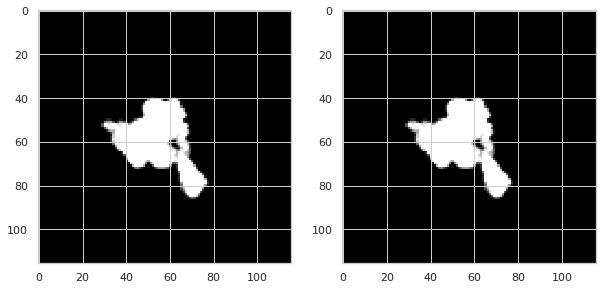

In [156]:
plot_train_results(0)

In [44]:
# plot_validation_results(0)

---

## dP/dQ plot

In [23]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [70]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [71]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [182]:
# 1000
# batch_size=256 --- 35.63  
# batch_size=512 --- 35.11
# batch_size=1024 --- 36.47
# batch_size=2048 --- 35.37

# 512 pairs
# batch_size=256 --- 18.34  
# batch_size=512 --- 18.56 -> 0.3625
# batch_size=1024 -- 16.94
# batch_size=2048 -- 17.17
# batch_size=4096 -- 17.29 ->  <<<<<<<<<<

# 1024 pairs
# batch_size=256 --- 32.85 -> 0.0358
# batch_size=512 --- 33.17 -> 0.032
# batch_size=4096 -- 33.58 -> 0.033 <<<<<<<<<<<<

# 2048 pairs
# batch_size=256 --- 65.87 -> 0.032
# batch_size=512 --- 65.54 -> 0.0320
# batch_size=4096 -- 68.22 -> 0.033 <<<<<<<<<<<<<

# 4096 pairs
# batch_size=256 --- 130.83 -> 0.032 
# batch_size=512 --- 131.52 -> 0.0321
# batch_size=1024 -- 135.54
# batch_size=2048 -- 134.86
# batch_size=4096 -- 136.48 -> 0.033 <<<<<<<<<<<<<<<<

# 8192 pairs
# batch_size=256 --- 264.07 -> 0.032
# batch_size=512 --- 260.43 -> 0.0318
# batch_size=1024 -- 279.60 -> 0.034
# batch_size=2048 -- 277.22 -> 0.034
# batch_size=4096 -- 274.30 -> 0.033
# batch_size=8192 --- resource exaustion

In [72]:
def init_d_p(batch_size):
    def d_p(p1, p2):
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=batch_size)
    return d_p

In [187]:
def estimate(dp, batch_size):
    start_time = time()
    idx1 = list(np.random.choice(test_idx, size=batch_size))
    idx2 = list(np.random.choice(test_idx, size=batch_size))

    q1_true = euler2quaternion([angles_true[i] for i in idx1])
    q2_true = euler2quaternion([angles_true[i] for i in idx2])

    p1 = [X[i] for i in idx1]
    p2 = [X[i] for i in idx2]

    dP_values = dp(p1, p2).T[0]
    dQ_values = d_q(q1_true, q2_true).numpy()
    return time()-start_time

In [189]:
AR_batch_sizes = [512, 1024, 2048, 4096]
PREDICTION_batch_sizes = [256, 512, 1024, 2048, 4096]
num_runs = 5

for ar_bs in AR_batch_sizes:
    for p_bs in PREDICTION_batch_sizes:
        avg = []
        for n in range(num_runs):
            dp = init_d_p(p_bs)
            avg.append(estimate(dp, ar_bs)/ar_bs)
        print(f"AR_batch_size={ar_bs} | PREDICTION_batch_size={p_bs} | TIME={np.mean(np.array(avg))}")

AR_batch_size=512 | PREDICTION_batch_size=256 | TIME=0.03299709325656295
AR_batch_size=512 | PREDICTION_batch_size=512 | TIME=0.0326569520868361
AR_batch_size=512 | PREDICTION_batch_size=1024 | TIME=0.03303157696500421
AR_batch_size=512 | PREDICTION_batch_size=2048 | TIME=0.03273899452760816
AR_batch_size=512 | PREDICTION_batch_size=4096 | TIME=0.03269322821870446
AR_batch_size=1024 | PREDICTION_batch_size=256 | TIME=0.03283156142570078
AR_batch_size=1024 | PREDICTION_batch_size=512 | TIME=0.031962563190609215
AR_batch_size=1024 | PREDICTION_batch_size=1024 | TIME=0.03250759243965149
AR_batch_size=1024 | PREDICTION_batch_size=2048 | TIME=0.032563598034903406
AR_batch_size=1024 | PREDICTION_batch_size=4096 | TIME=0.03243258027359843
AR_batch_size=2048 | PREDICTION_batch_size=256 | TIME=0.03208884799387306
AR_batch_size=2048 | PREDICTION_batch_size=512 | TIME=0.03225457370281219
AR_batch_size=2048 | PREDICTION_batch_size=1024 | TIME=0.03227765960618854
AR_batch_size=2048 | PREDICTION_bat

In [190]:
AR_batch_sizes = [512, 1024, 2048, 4096]
PREDICTION_batch_sizes = [256, 512, 1024, 2048, 4096]
num_runs = 5

for ar_bs in AR_batch_sizes:
    for p_bs in PREDICTION_batch_sizes:
        avg = []
        for n in range(num_runs):
            dp = init_d_p(p_bs)
            avg.append(estimate(dp, ar_bs)/ar_bs)
        print(f"AR_batch_size={ar_bs} | PREDICTION_batch_size={p_bs} | TIME={np.median(np.array(avg))}")

AR_batch_size=512 | PREDICTION_batch_size=256 | TIME=0.03284018533304334
AR_batch_size=512 | PREDICTION_batch_size=512 | TIME=0.032505986746400595
AR_batch_size=512 | PREDICTION_batch_size=1024 | TIME=0.03292833408340812
AR_batch_size=512 | PREDICTION_batch_size=2048 | TIME=0.03260888298973441
AR_batch_size=512 | PREDICTION_batch_size=4096 | TIME=0.032590655609965324
AR_batch_size=1024 | PREDICTION_batch_size=256 | TIME=0.032476814929395914
AR_batch_size=1024 | PREDICTION_batch_size=512 | TIME=0.03191678272560239
AR_batch_size=1024 | PREDICTION_batch_size=1024 | TIME=0.032187903532758355
AR_batch_size=1024 | PREDICTION_batch_size=2048 | TIME=0.032117009395733476
AR_batch_size=1024 | PREDICTION_batch_size=4096 | TIME=0.032587841153144836
AR_batch_size=2048 | PREDICTION_batch_size=256 | TIME=0.03245340252760798
AR_batch_size=2048 | PREDICTION_batch_size=512 | TIME=0.03232990449760109
AR_batch_size=2048 | PREDICTION_batch_size=1024 | TIME=0.03240812395233661
AR_batch_size=2048 | PREDICTIO

In [73]:
start_time = time()

d_p = init_d_p(512)

idx1 = list(np.random.choice(test_idx, size=1024))
idx2 = list(np.random.choice(test_idx, size=1024))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()
time()-start_time

37.03323435783386

In [46]:
start_timenp.savez("data/5j0n/5j0n_DE_dPdQ_plot_full_add_loss", dP_values, dQ_values)

In [47]:
data = np.load("data/5j0n/5j0n_DE_dPdQ_plot_full_add_loss.npz")
dP_values, dQ_values = data['arr_0'], data['arr_1']

<Figure size 432x288 with 0 Axes>

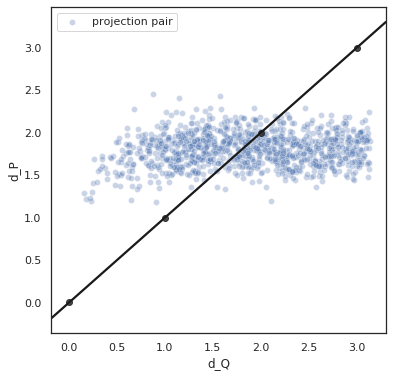

<Figure size 432x288 with 0 Axes>

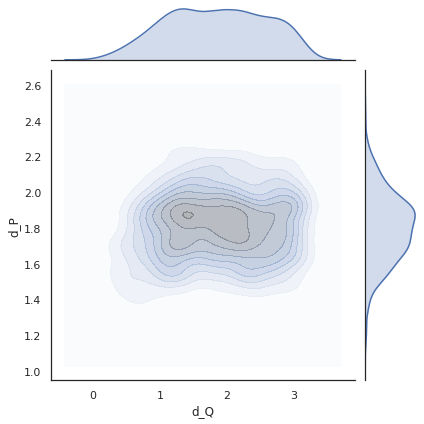

Variance = 0.731567742792469
Min. angle recovery loss possible = 0.5346687144797273


In [74]:
plot_dP_dQ(dP_values, dQ_values)

In [26]:
MAE(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float32, numpy=0.21109173>

# 2. Angle Recovery

## Angle Recovery

Perfect distances. Learning rate 0.01

In [83]:
from cryoem.angle_recovery import train_angle_recovery

In [76]:
# X = tf.cast(X, dtype=tf.float64)
# X = X.numpy()

In [ ]:
# 175 sec with 4096 (10*512)

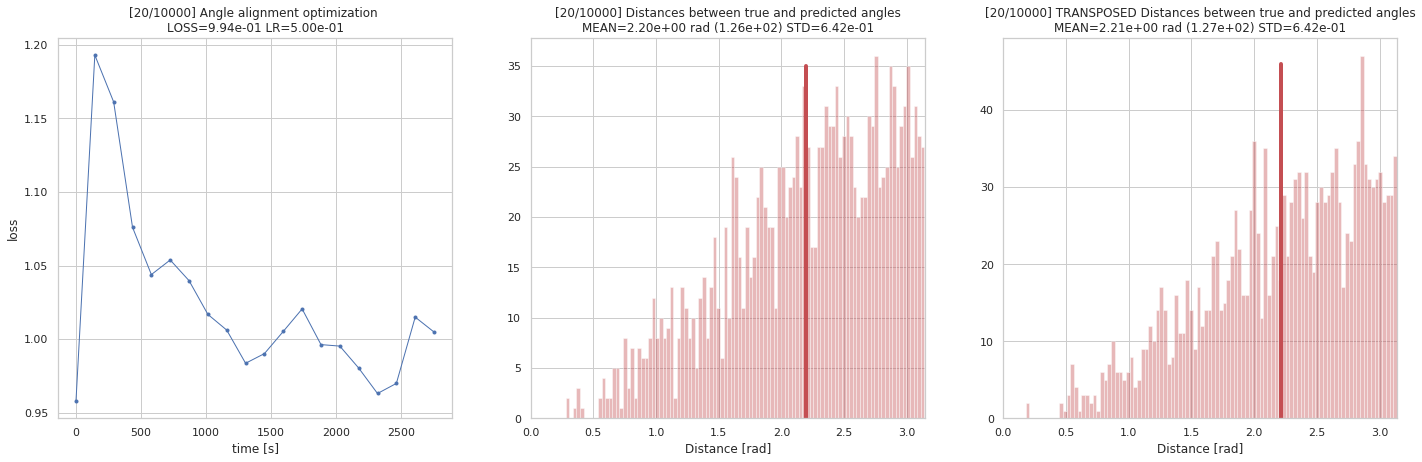

KeyboardInterrupt: 

In [84]:
q_predicted, losses, q_all = train_angle_recovery(steps=10000, 
                                                   batch_size=512, 
                                                   in_data=X[test_idx], 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.5,
                                                   angles_true=y[test_idx],
                                                   optimization=True,
                                                 file_name="data/5j0n/angle_recovery")

In [25]:
data = np.load("data/5j0n/angle_recovery_polynomial.npz")
q_predicted, losses, q_all = data['arr_0'], data['arr_1'], data['arr_2']

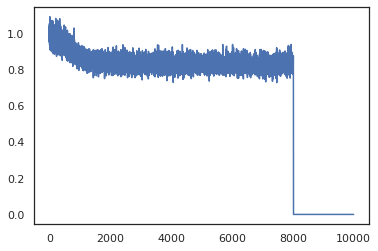

In [29]:
plt.plot(losses)

In [31]:
from cryoem.conversions import quaternion2euler
angles_predicted = quaternion2euler(q_predicted).numpy()%(2*np.pi)
np.save("data/5j0n/predicted_angles_siamese_kld.npy", angles_predicted)

##### Plots

In [61]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

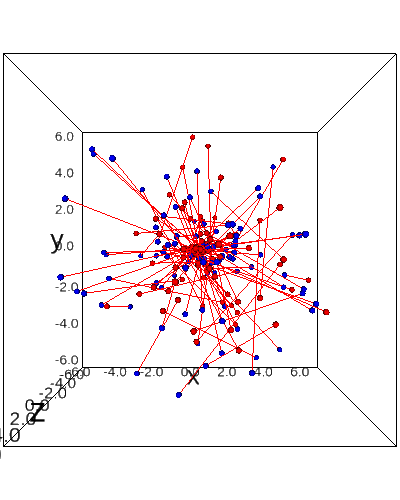

In [65]:
plot_iterations_polar_plot(q_all, angles_true[test_idx], interval=100, selected=range(102));

In [66]:
ipv.screenshot()

Output()

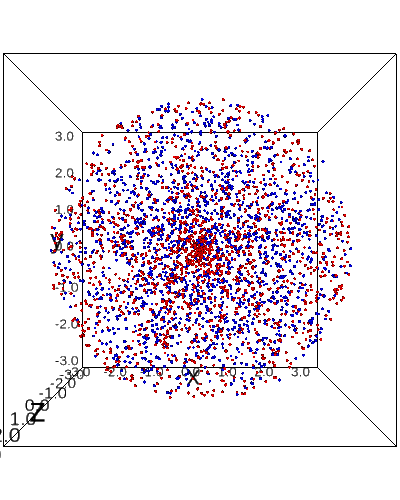

In [67]:
plot_iterations_rotvec(q_all, angles_true[test_idx], interval=100);

In [68]:
ipv.screenshot()

Output()

In [69]:
from cryoem.plots import plot_images

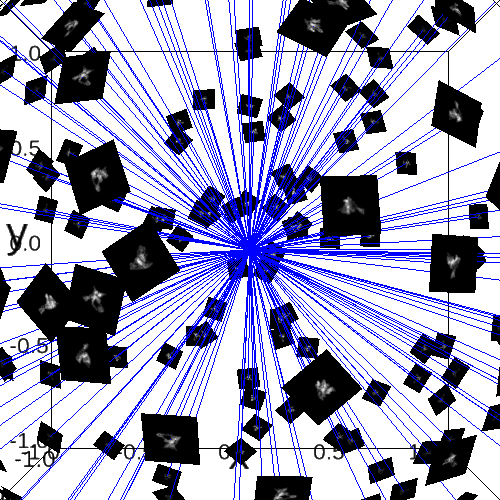

In [70]:
plot_images(angles_predicted, projections, indices=range(200), img_size_scale=0.1)

In [71]:
ipv.screenshot()

Output()

---

# Angle Alignment

#### Prediction angles from previous phase that we want to align with true angles

---

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [45]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

In [54]:

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R
from cryoem.conversions import euler2quaternion, d_q


def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R, q_predicted):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return q_predicted_rotated

def loss_alignment(m, a_R, q_predicted, q_true):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, optimizer, learning_rate, learning_rate_power, angles_true, angles_predicted):
    
    collect_data = []

    optimizer = optimizer(learning_rate=learning_rate, learning_rate_power=learning_rate_power)

    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    euler = tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) #np.zeros(6, dtype=np.float64)
    a_R = [tf.Variable(euler)]

    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

        # Compute distances between projections
        qt = [q_true[i]      for i in idx]
        qp = [q_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(m, a_R, qp, qt)
        optimizer.apply_gradients(zip(gradients, a_R))

        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            qu = update_quaternion(m, a_R, q_predicted)

            collect_data.append(qu.numpy())

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))

            # Distance count subplot (batches)
            qpr = update_quaternion(m, a_R, qp)
            d1 = d_q(qpr, qt)
            axs[0].set_xlim(0, np.pi)
            #axs[0].set_ylim(0, batch_size)
            axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

            # Distance count subplot (full)
            q_predicted_rot = update_quaternion(m, a_R, q_predicted)
            d2 = d_q(q_predicted_rot, q_true)
            axs[2].set_xlim(0, np.pi)
            # axs[2].set_ylim(0, len(angles_true))
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(.1)


        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

        if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
            break;

    print(report)
    print("---")
    return m, a_R, losses, np.array(collect_data)

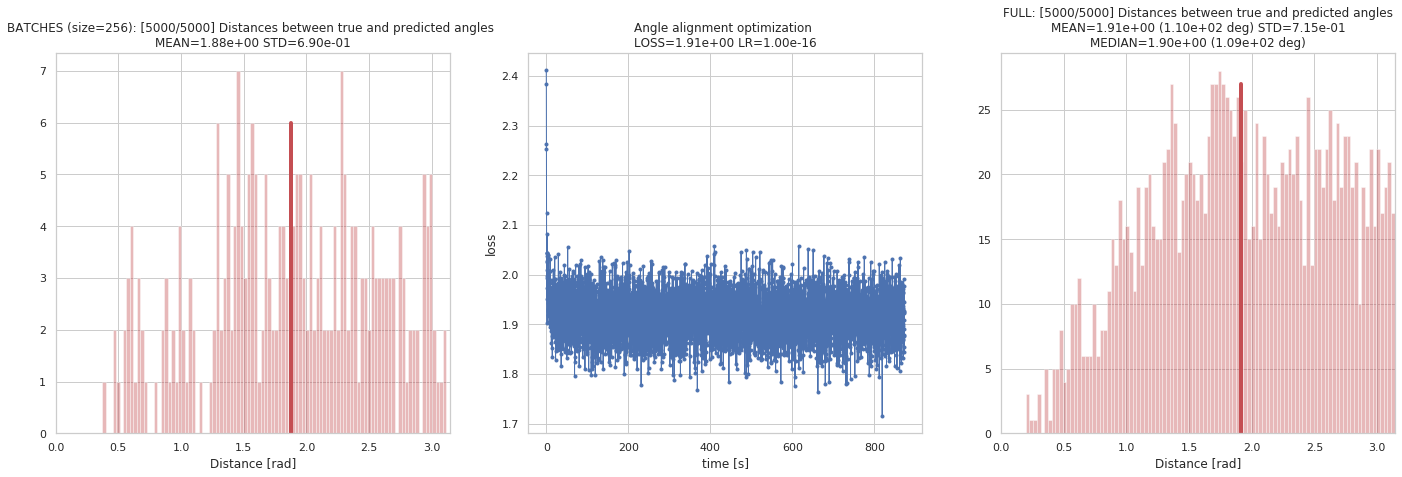

step 500/5000 (86s): loss = 1.93e+00
step 1000/5000 (173s): loss = 1.92e+00
step 1500/5000 (258s): loss = 1.92e+00
step 2000/5000 (346s): loss = 1.91e+00
step 2500/5000 (433s): loss = 1.92e+00
step 3000/5000 (520s): loss = 1.91e+00
step 3500/5000 (609s): loss = 1.92e+00
step 4000/5000 (698s): loss = 1.92e+00
step 4500/5000 (788s): loss = 1.92e+00
step 5000/5000 (874s): loss = 1.91e+00

---


In [33]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=5000, 
                                                 batch_size=256, 
                                                 learning_rate=0.1, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [34]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([ 5.99795062,  6.35418195,  0.4896981 ,  1.46645199, -0.37136765,
         6.10243942]),
 1.8764334622668768)

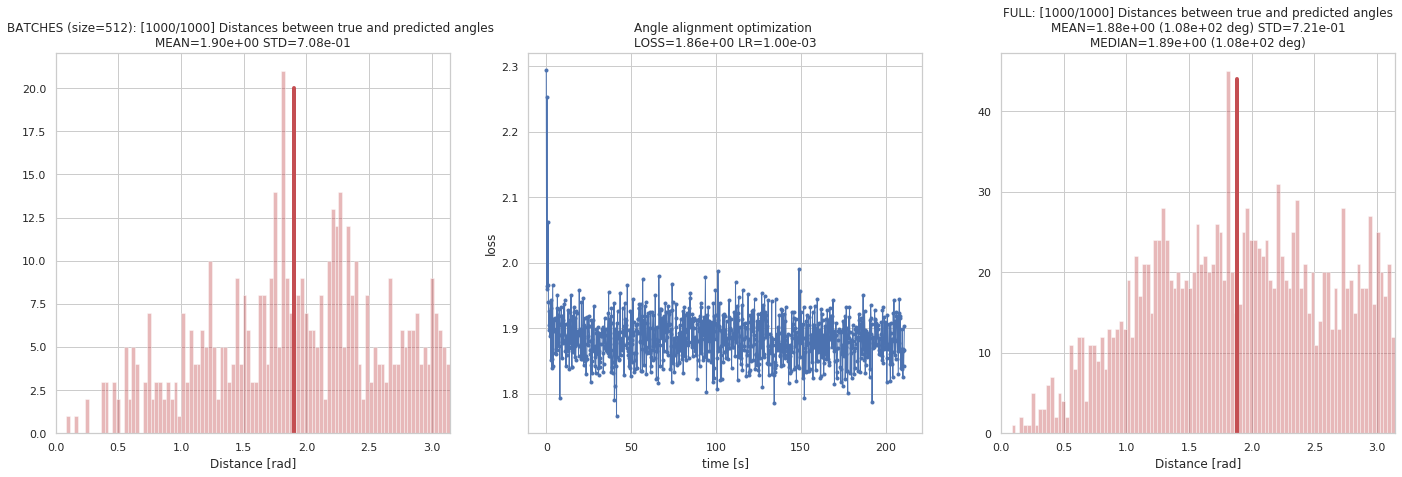

step 100/1000 (20s): loss = 1.91e+00
step 200/1000 (43s): loss = 1.88e+00
step 300/1000 (64s): loss = 1.89e+00
step 400/1000 (84s): loss = 1.89e+00
step 500/1000 (106s): loss = 1.89e+00
step 600/1000 (127s): loss = 1.89e+00
step 700/1000 (148s): loss = 1.88e+00
step 800/1000 (170s): loss = 1.88e+00
step 900/1000 (190s): loss = 1.88e+00
step 1000/1000 (212s): loss = 1.88e+00

---


In [60]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, -1.0],
                                                 steps=1000, 
                                                 batch_size=512, 
                                                 optimizer=Ftrl,
                                                 learning_rate=0.1,
                                                 learning_rate_power=-2.,
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [61]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, -1.0],
 array([-0.07603173, -0.40875797,  0.30534186,  4.89622495, -0.89862279,
         3.34718623]),
 1.9026925279817286)

##### Plots

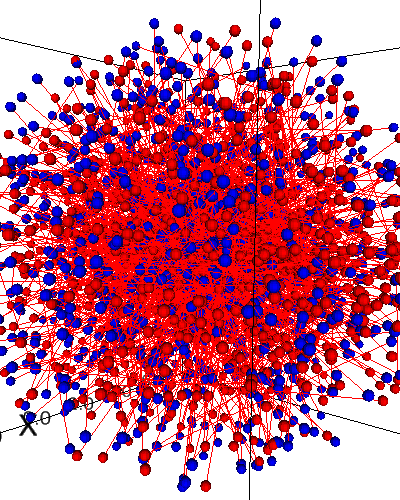

In [83]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=100);

In [84]:
ipv.screenshot()

Output()

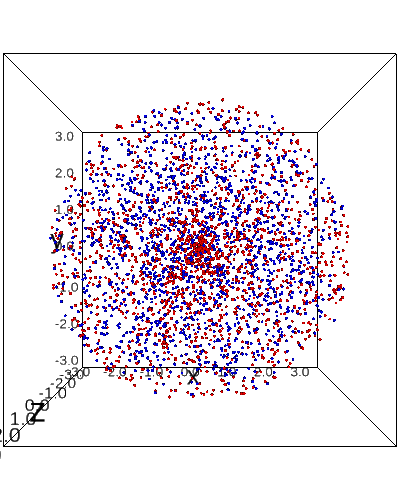

In [85]:
plot_iterations_rotvec(collect_data, angles_true[test_idx]);

In [86]:
ipv.screenshot()

Output()

In [62]:
qpn = euler2quaternion(angles_predicted)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted_rotated = quaternion2euler(qpa).numpy()

np.save("data/5j0n/predicted_angles_siamese_updated_T.npy", angles_predicted_rotated)

In [67]:
np.save("data/5j0n/projections.npy", projections[test_idx])

In [51]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted_updated.png')